# Finite-strain elastoplasticity within the logarithmic strain framework

This demo is dedicated to the resolution of a finite-strain elastoplastic problem using the logarithmic strain framework proposed in [@miehe_anisotropic_2002].

## Logarithmic strains 

This framework expresses constitutive relations between the Hencky strain measure $\boldsymbol{H} = \dfrac{1}{2}\log (\boldsymbol{F}^T\cdot\boldsymbol{F})$ and its dual stress measure $\boldsymbol{T}$. This approach makes it possible to extend classical small strain constitutive relations to a finite-strain setting. In particular, the total (Hencky) strain can be split additively into many contributions (elastic, plastic, thermal, swelling, etc.) e.g. $\boldsymbol{H}=\boldsymbol{H}^e+\boldsymbol{H}^p$. Its trace is also linked with the volume change $J=\exp(\operatorname{tr}(\boldsymbol{H}))$. As a result, the deformation gradient $\boldsymbol{F}$ is used for expressing the Hencky strain $\boldsymbol{H}$, a small-strain constitutive law is then written for the $(\boldsymbol{H},\boldsymbol{T})$-pair and the dual stress $\boldsymbol{T}$ is then post-processed to an appropriate stress measure such as the Cauchy stress $\boldsymbol{\sigma}$ or Piola-Kirchhoff stresses.

## `MFront` implementation

The logarithmic strain framework discussed in the previous paragraph consists merely as a pre-processing and a post-processing stages of the behaviour integration. The pre-processing stage compute the logarithmic strain and its increment and the post-processing stage inteprets the stress resulting from the behaviour integration as the dual stress $\boldsymbol{T}$ and convert it to the Cauchy stress.

`MFront` provides the `@StrainMeasure` keyword that allows to specify which strain measure is used by the behaviour. When choosing the `Hencky` strain measure, `MFront` automatically generates those pre- and post-processing stages, allowing the user to focus on the behaviour integration.

This leads to the following implementation (see the [small-strain elastoplasticity example](https://thelfer.github.io/mgis/web/mgis_fenics_small_strain_elastoplasticity.html) for details about the various implementations available):

```cpp
@DSL Implicit;

@Behaviour LogarithmicStrainPlasticity;
@Author Thomas Helfer/Jérémy Bleyer;
@Date 07 / 04 / 2020;

@StrainMeasure Hencky;

@Algorithm NewtonRaphson;
@Epsilon 1.e-14;
@Theta 1;

@MaterialProperty stress s0;
s0.setGlossaryName("YieldStress");
@MaterialProperty stress H0;
H0.setEntryName("HardeningSlope");

@Brick StandardElastoViscoPlasticity{
  stress_potential : "Hooke" {
	    young_modulus : 210e9,
        poisson_ratio : 0.3
        },
  inelastic_flow : "Plastic" {
    criterion : "Mises",
    isotropic_hardening : "Linear" {H : "H0", R0 : "s0"}
  }
};
```

## `FEniCS` implementation

We define a box mesh representing half of a beam oriented along the $x$-direction. The beam will be fully clamped on its left side and symmetry conditions will be imposed on its right extremity. The loading consists of a uniform self-weight.


<img src="finite_strain_plasticity_solution.png" width="500">


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from dolfin import *
import mgis.fenics as mf
import numpy as np
import ufl

length, width, height = 1., 0.04, 0.1
nx, ny, nz = 30, 5, 8
mesh = BoxMesh(Point(0, -width/2, -height/2.), Point(length, width/2, height/2.), nx, ny, nz)

V = VectorFunctionSpace(mesh, "CG", 2)
u = Function(V, name="Displacement")

def left(x, on_boundary):
    return near(x[0], 0) and on_boundary
def right(x, on_boundary):
    return near(x[0], length) and on_boundary

bc = [DirichletBC(V, Constant((0.,)*3), left),
      DirichletBC(V.sub(0), Constant(0.), right)]

selfweight = Expression(("0", "0", "-t*qmax"), t=0., qmax = 50e6, degree=0)

file_results = XDMFFile("results/finite_strain_plasticity.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

The `MFrontNonlinearMaterial` instance is loaded from the `MFront` `LogarithmicStrainPlasticity` behaviour. This behaviour is a finite-strain behaviour (`material.is_finite_strain=True`) which relies on a kinematic description using the total deformation gradient $\boldsymbol{F}$. By default, a `MFront` behaviour always returns the Cauchy stress as the stress measure after integration. However, the stress variable dual to the deformation gradient is the first Piola-Kirchhoff (PK1) stress. An internal option of the MGIS interface is therefore used in the finite-strain context to return the PK1 stress as the "flux" associated to the "gradient" $\boldsymbol{F}$. Both quantities are non-symmetric tensors, aranged as a 9-dimensional vector in 3D following [`MFront` conventions on tensors](http://tfel.sourceforge.net/tensors.html).

In [2]:
material = mf.MFrontNonlinearMaterial("./src/libBehaviour.so",
                                      "LogarithmicStrainPlasticity",
                                      material_properties={"YieldStrength": 250e6,
                                                           "HardeningSlope": 1e6})
print(material.behaviour.getBehaviourType())
print(material.behaviour.getKinematic())
print(material.get_gradient_names(), material.get_gradient_sizes())
print(material.get_flux_names(), material.get_flux_sizes())

StandardFiniteStrainBehaviour
F_CAUCHY
['DeformationGradient'] [9]
['FirstPiolaKirchhoffStress'] [9]


The `MFrontNonlinearProblem` instance must therefore register the deformation gradient as `Identity(3)+grad(u)`. This again done automatically since `"DeformationGradient"` is a predefined gradient. The following message will be shown upon calling `solve`:
```
Automatic registration of 'DeformationGradient' as I + (grad(Displacement)).
```
The loading is then defined and, as for the [small-strain elastoplasticity example](https://thelfer.github.io/mgis/web/mgis_fenics_small_strain_elastoplasticity.html), state variables include the `ElasticStrain` and `EquivalentPlasticStrain` since the same behaviour is used as in the small-strain case with the only difference that the total strain is now given by the Hencky strain measure. In particular, the `ElasticStrain` is still a symmetric tensor (vector of dimension 6). Note that it has not been explicitly defined as a state variable in the `MFront` behaviour file since this is done automatically when using the `IsotropicPlasticMisesFlow` parser.

Finally, we setup a few parameters of the Newton non-linear solver.

In [3]:
problem = mf.MFrontNonlinearProblem(u, material, bcs=bc)
problem.set_loading(dot(selfweight, u)*dx)

epsel = problem.get_state_variable("ElasticStrain")
print("'ElasticStrain' shape:", ufl.shape(epsel))

prm = problem.solver.parameters
prm["absolute_tolerance"] = 1e-6
prm["relative_tolerance"] = 1e-6
prm["linear_solver"] = "mumps"

'ElasticStrain' shape: (6,)


During the load incrementation, we monitor the evolution of the vertical downwards displacement at the middle of the right extremity.

This simulation is a bit heavy to run so we suggest running it in parallel:
```bash
mpirun -np 4 python3 finite_strain_elastoplasticity.py
```

In [4]:
Nincr = 30
load_steps = np.linspace(0., 1., Nincr+1)
results = np.zeros((Nincr+1, 3))
for (i, t) in enumerate(load_steps[1:]):
    selfweight.t = t
    print("Increment ", i+1)
    problem.solve(u.vector())
    p0 = problem.get_state_variable("EquivalentPlasticStrain", project_on=("DG", 0))

    file_results.write(u, t)
    file_results.write(p0, t)
    
    results[i+1, 0] = -u(length, 0, 0)[2]
    results[i+1, 1] = t

Increment  1
Automatic registration of 'DeformationGradient' as I + (grad(Displacement)).

Automatic registration of 'Temperature' as a Constant value = 293.15.

Increment  2
Increment  3
Increment  4
Increment  5
Increment  6
Increment  7
Increment  8
Increment  9
Increment  10
Increment  11
Increment  12
Increment  13
Increment  14
Increment  15
Increment  16
Increment  17
Increment  18
Increment  19
Increment  20
Increment  21
Increment  22
Increment  23
Increment  24
Increment  25
Increment  26
Increment  27
Increment  28
Increment  29
Increment  30


The load-displacement curve exhibits a classical elastoplastic behaviour rapidly followed by a stiffening behaviour due to membrane catenary effects. 

<IPython.core.display.Javascript object>


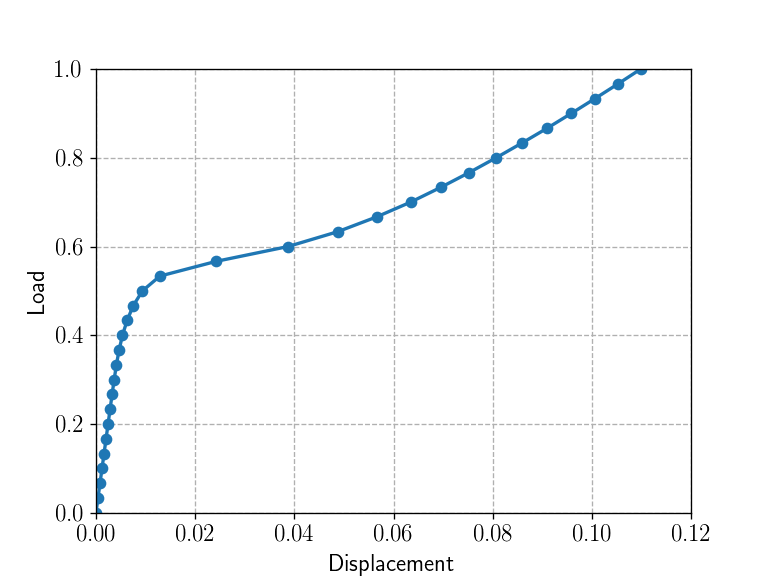

In [5]:
plt.figure()
plt.plot(results[:, 0], results[:, 1], "-o")
plt.xlabel("Displacement")
plt.ylabel("Load");